In [40]:
#needed after restructuring of directory
import os
os.chdir('/Users/alexchandler/UFC_Prediction_2022')
os.getcwd()

'/Users/alexchandler/UFC_Prediction_2022'

In [4]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
os.chdir('/Users/alexchandler/UFC_Prediction_2022/src')
from functions import *
os.chdir('/Users/alexchandler/UFC_Prediction_2022')#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('src/content/data/processed/ufc_fights.csv',low_memory=False)

In [6]:
#scores a model
def model_score(dataframe,features, iloc_val = 3200, _max_iter = 2000):
    yyy=dataframe['result'].iloc[0:iloc_val]
    XXX=dataframe[features].iloc[0:iloc_val]
    XXXscaler = preprocessing.StandardScaler().fit(XXX)
    XXX_scaled = XXXscaler.transform(XXX) 
    winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=_max_iter, fit_intercept=False)
    return cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
    
#CODE FOR THE GREEDY ALGORITHM FOR FEATURE SELECTION
def greedy(dataframe, features, subsetsize, iloc_val=3200, _max_iter = 2000):
    i=0
    best_stats=[]
    s=set(features)
    subsets=list(map(set, itertools.combinations(s, subsetsize))) #subsets of size (subsetsize)
    possible_stat_dict = {}
    scores={0:0}
    for stat_pair in subsets:
        possible_stat_dict[tuple(stat_pair)]=0
    while (i==0) or (scores[i]>scores[i-1]):
        i+=1
        for stat_pair in list(possible_stat_dict.keys()):
            stats_temp = best_stats+list(stat_pair)
            possible_stat_dict[tuple(stat_pair)]=model_score(ufc_fights_winner,stats_temp,iloc_val,_max_iter)
        max_key = max(possible_stat_dict, key=possible_stat_dict.get)
        best_stats.extend(list(max_key))
        scores[i]=possible_stat_dict[max_key]
        possible_stat_dict.pop(max_key)
        print(best_stats,scores[i])
    return (best_stats[:-subsetsize], scores[i-1])

In [7]:
# cleans method column so 'M-DEC' and 'U-DEC' count as decision, 
# and 'S-DEC', 'doctor stoppage', 'overturned' etc counts as 'bullshit'
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['KO/TKO', 'bullshit', 'DEC', 'SUB'], dtype=object)

In [8]:
#adding stance 
ufc_fights['fighter_stance']=stance_vect(ufc_fights['fighter'])
ufc_fights['opponent_stance']=stance_vect(ufc_fights['opponent'])

In [34]:
#WHY AM I USING u'' i.e. unicode... r'' takes less memory space. Was there a reason for using u?
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights_winner['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights_winner['fighter_age']!='unknown')&(ufc_fights_winner['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights_winner['fighter_height']!='unknown')&(ufc_fights_winner['opponent_height']!='unknown')
reach_mask=(ufc_fights_winner['fighter_reach']!='unknown')&(ufc_fights_winner['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights_winner['fighter_wins'] != 'unknown' )& (ufc_fights_winner['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights_winner['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights_winner['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', 
                   u'fighter_losses', 
                   u'fighter_L5Y_wins',
                   u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', 
                   u'fighter_L2Y_losses',
                   u'fighter_ko_wins',
                   u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',
                   u'fighter_L5Y_ko_losses',
                   u'fighter_L2Y_ko_wins',
                   u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',
                   u'fighter_sub_losses',
                   u'fighter_L5Y_sub_wins',
                   u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', 
                   u'fighter_L2Y_sub_losses',
                   
                   u'opponent_wins', 
                   u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']


#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#adding alternate record differences to ufc_fights
record_statistics_diff_alt = []
half_length=int(len(record_statistics)/2)
for i in range(0,half_length,2):
    ufc_fights_winner[record_statistics[i]+'_diff_2_alt']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+1]]-ufc_fights_winner[record_statistics[i+half_length]]+ufc_fights_winner[record_statistics[i+1+half_length]]

   
    record_statistics_diff_alt.append(record_statistics[i]+'_diff_2_alt')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)

physical_stats_diff = ['fighter_age_diff', 'fighter_age_diff_adj', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights (inf-inf abs-abs)
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
#adding other style of punch differences to ufc_fights (inf-abs abs-inf)
punch_statistics_diff_alt=[]
quarter_length=int(len(punch_statistics)/4)
for i in range(quarter_length):
    ufc_fights_winner[punch_statistics[i]+'_diff_2_alt']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+3*quarter_length]]-ufc_fights_winner[punch_statistics[i+2*quarter_length]]+ufc_fights_winner[punch_statistics[i+quarter_length]]
    punch_statistics_diff_alt.append(punch_statistics[i]+'_diff_2_alt')
    
    
    
fight_math_stats=['4-fighter_score_diff',
 '9-fighter_score_diff',
 '15-fighter_score_diff',
 '1-fight_math',
 '6-fight_math']
    
possible_stats_diff =record_statistics_diff+record_statistics_diff_alt+physical_stats_diff+punch_statistics_diff+punch_statistics_diff_alt+fight_math_stats
possible_stats_all = possible_stats_diff+record_statistics+physical_stats+punch_statistics
possible_stats_diff_restricted =record_statistics_diff+physical_stats_diff+punch_statistics_diff+fight_math_stats



In [10]:
ufc_fights_winner['result'].unique()

array(['W', 'L'], dtype=object)

In [11]:
ufc_fights_winner['method'].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

In [12]:
#changing columns saved as strings to floats
ufc_fights_winner['fighter_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_winner['fighter_height'] = ufc_fights_winner['fighter_height'].apply(float)
ufc_fights_winner['fighter_reach'] = ufc_fights_winner['fighter_reach'].apply(float)
ufc_fights_winner['opponent_age'] = ufc_fights_winner['opponent_age'].apply(float)
ufc_fights_winner['opponent_height'] = ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['opponent_reach'] = ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_winner['fighter_stance'] = ufc_fights_winner['fighter_stance'].apply(float)
ufc_fights_winner['opponent_stance'] = ufc_fights_winner['opponent_stance'].apply(float)

In [13]:
#adding an age_diff column and and age column adjusted to measure difference from prime age
ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age']-ufc_fights_winner['opponent_age']
ufc_fights_winner['fighter_age_diff_adj'] = (ufc_fights_winner['fighter_age']-30).apply(abs)-(ufc_fights_winner['opponent_age']-30).apply(abs)


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_36743/723622036.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age']-ufc_fights_winner['opponent_age']
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_36743/723622036.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ufc_fights_winner['fighter_age_diff_adj'] = (ufc_fights_winner['fighter_age']-30).apply(abs)-(ufc_fights_winner['opponent_age']-30).apply(abs)


In [14]:
# LR model score with just record statistics considered
model_score(ufc_fights_winner,record_statistics)

0.566875

In [15]:
# LR model score with just record statistics differences considered (higher)
model_score(ufc_fights_winner,record_statistics_diff)

0.569375

In [16]:
# LR model score with just record statistics differences considered (higher)
model_score(ufc_fights_winner,record_statistics_diff_alt)

0.568125

In [17]:
model_score(ufc_fights_winner,record_statistics_diff+record_statistics_diff_alt)

0.5690625

In [18]:
# LR model score with just physical statistics considered
model_score(ufc_fights_winner,physical_stats)

0.5825

In [19]:
# LR model score with just physical statistics differences considered (lower... but not too much)
model_score(ufc_fights_winner,physical_stats_diff)

0.5828125

In [20]:
# LR model score with just punch statistics considered
model_score(ufc_fights_winner,punch_statistics)

0.5790625

In [21]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff)

0.5800000000000001

In [22]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff_alt)

0.5521875

In [23]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff+punch_statistics_diff_alt)

0.5796874999999999

In [24]:
#score just from fight math
model_score(ufc_fights_winner,fight_math_stats)

0.5765625

In [25]:
#model score with all possible stats (absolute and differences) (slightly lower)
model_score(ufc_fights_winner,possible_stats_all)

0.6071875

In [26]:
#model score with all possible stats (only differences)
model_score(ufc_fights_winner,possible_stats_diff)

0.6187499999999999

1 0.45
2 0.36250000000000004
3 0.55
4 0.6125
5 0.6050000000000001
6 0.5791666666666667
7 0.5785714285714286
8 0.6156250000000001
9 0.6
10 0.6075
11 0.6022727272727273
12 0.6125
13 0.6134615384615385
14 0.6035714285714285
15 0.615
16 0.5890624999999999
17 0.6014705882352942
18 0.5888888888888889
19 0.5710526315789473
20 0.58125
21 0.5797619047619048
22 0.5874999999999999
23 0.5945652173913043
24 0.6041666666666667
25 0.608
26 0.6000000000000001
27 0.5972222222222222
28 0.5839285714285715
29 0.5844827586206898
30 0.5858333333333334
31 0.5838709677419355
32 0.59375
33 0.5871212121212122
34 0.5933823529411765
35 0.5950000000000001
36 0.5861111111111111
37 0.5905405405405405
38 0.5855263157894737
39 0.6006410256410256
40 0.605625
41 0.6018292682926829
42 0.5922619047619049
43 0.5959302325581395
44 0.6005681818181818
45 0.6033333333333333
46 0.592391304347826
47 0.598936170212766
48 0.6036458333333334
49 0.5989795918367347
50 0.6005
51 0.6063725490196079
52 0.5985576923076923
53 0.6061320754

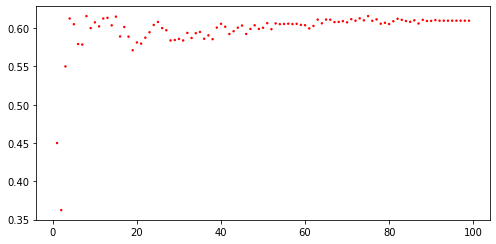

In [27]:
#lets see the best number of examples to use. Looks like 40*75
from sklearn.feature_selection import SelectKBest, chi2
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights_winner,possible_stats,40*i))
    yy.append(model_score(ufc_fights_winner,possible_stats,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [31]:
age_adj=ufc_fights_winner['fighter_age_diff_adj'].unique()
age_adj.sort()
age_adj

array([-13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.])

In [40]:
#testing fighter_age_diff_adj for different "optimal ages"...
#interesting... outperforms fighter_age_diff only at 23... meaning that 23 is the optimal fighting age??
for j in range(18,40):
    ufc_fights_winner['fighter_age_diff_adj'] = (ufc_fights_winner['fighter_age']-j).apply(abs)-(ufc_fights_winner['opponent_age']-j).apply(abs)
    print(j,model_score(ufc_fights_winner,['fighter_age_diff_adj']))

18 0.57875
19 0.57875
20 0.57875
21 0.57875
22 0.57875
23 0.58
24 0.5778125000000001
25 0.575625
26 0.5665625
27 0.5562499999999999
28 0.534375
29 0.519375
30 0.49406249999999996
31 0.5009375
32 0.5334375
33 0.5496875
34 0.565625
35 0.5706249999999999
36 0.5774999999999999
37 0.5778125
38 0.575
39 0.57625


In [27]:
ufc_fights_winner['fighter_age_diff_adj'] = (ufc_fights_winner['fighter_age']-23).apply(abs)-(ufc_fights_winner['opponent_age']-23).apply(abs)



In [28]:
# adds one stat at a time, always choosing the one that increases score by the most (greedy)
# best so far at .629 (4/16 improved to .6396 after fixing fight math and fight score)
greedy(ufc_fights_winner, possible_stats_diff, 1,40*75)

['fighter_age_diff_adj'] 0.5826666666666667
['fighter_age_diff_adj', '4-fighter_score_diff'] 0.616
['fighter_age_diff_adj', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2'] 0.6316666666666666
['fighter_age_diff_adj', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2_alt'] 0.6343333333333333
['fighter_age_diff_adj', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2_alt', '1-fight_math'] 0.6353333333333333
['fighter_age_diff_adj', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2_alt', '1-fight_math', 'fighter_L2Y_wins_diff_2_alt'] 0.636
['fighter_age_diff_adj', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2_alt', '1-fight_math', 'fighter_L2Y_wins_diff_2_alt', 'fighter_abs_reversals_avg_diff_

(['fighter_age_diff_adj',
  '4-fighter_score_diff',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_inf_distance_strikes_landed_avg_diff_2_alt',
  '1-fight_math',
  'fighter_L2Y_wins_diff_2_alt'],
 0.636)

In [29]:
# adds two stats at a time, always choosing the two that increases score by the most (greedy)
# best so far at .6426
greedy(ufc_fights_winner, possible_stats_diff, 2,40*75)

['fighter_age_diff', '4-fighter_score_diff'] 0.6186666666666666
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2'] 0.6346666666666667
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2', 'fighter_inf_pass_avg_diff_2', 'fighter_L2Y_sub_wins_diff_2_alt'] 0.638
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2', 'fighter_inf_pass_avg_diff_2', 'fighter_L2Y_sub_wins_diff_2_alt', 'fighter_inf_total_strikes_attempts_avg_diff_2_alt', 'fighter_inf_body_strikes_attempts_avg_diff_2_alt'] 0.6393333333333333
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_distance_strikes_landed_avg_diff_2', 'fighter_inf_pass_avg_diff_2', 'fighter_L2Y_sub_wins_diff_2_alt', 'fighter_inf_total_st

(['fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_inf_distance_strikes_landed_avg_diff_2',
  'fighter_inf_pass_avg_diff_2',
  'fighter_L2Y_sub_wins_diff_2_alt',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
  'fighter_L2Y_wins_diff_2',
  '1-fight_math',
  'fighter_age_diff',
  'fighter_inf_body_strikes_attempts_avg_diff_2_alt'],
 0.6413333333333333)

In [30]:
greedy(ufc_fights_winner, possible_stats_diff, 3,40*75)

['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff'] 0.6336666666666667
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_inf_total_strikes_attempts_avg_diff_2_alt', 'fighter_inf_body_strikes_attempts_avg_diff_2_alt', 'fighter_ko_losses_diff_2'] 0.6386666666666667
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_inf_total_strikes_attempts_avg_diff_2_alt', 'fighter_inf_body_strikes_attempts_avg_diff_2_alt', 'fighter_ko_losses_diff_2', 'fighter_inf_pass_avg_diff_2', 'fighter_inf_total_strikes_attempts_avg_diff_2_alt', 'fighter_inf_head_strikes_landed_avg_diff_2'] 0.642
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_inf_total_strikes_attempts_avg_diff_2_alt', 'fighter_inf_body_strikes_attempts_avg_diff_2_alt', 'fighter_ko_losses_diff_2', 'fighter_inf_pass_avg_diff_2', 'fighter_inf_total_strikes_a

(['fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
  'fighter_ko_losses_diff_2',
  'fighter_inf_pass_avg_diff_2',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_L2Y_sub_wins_diff_2',
  'fighter_inf_reversals_avg_diff_2',
  'fighter_L2Y_ko_wins_diff_2_alt',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_ko_losses_diff_2',
  'fighter_inf_reversals_avg_diff_2',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_ko_losses_diff_2'],
 0.6443333333333333)

In [32]:
list(set(['fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
  'fighter_ko_losses_diff_2',
  'fighter_inf_pass_avg_diff_2',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_L2Y_sub_wins_diff_2',
  'fighter_inf_reversals_avg_diff_2',
  'fighter_L2Y_ko_wins_diff_2_alt',
  'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_ko_losses_diff_2',
  'fighter_inf_reversals_avg_diff_2',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_ko_losses_diff_2']))

['fighter_age_diff',
 'fighter_L2Y_ko_wins_diff_2_alt',
 'fighter_inf_head_strikes_landed_avg_diff_2',
 'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
 'fighter_ko_losses_diff_2',
 'fighter_inf_pass_avg_diff_2',
 'fighter_inf_reversals_avg_diff_2',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
 '4-fighter_score_diff',
 'fighter_L2Y_sub_wins_diff_2']

In [33]:
# current best cross val score is at .642 with ['fighter_age_diff','4-fighter_score_diff','fighter_abs_total_strikes_landed_avg_diff_2','fighter_inf_sub_attempts_avg_diff_2_alt','fighter_inf_sig_strikes_landed_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','1-fight_math','fighter_inf_body_strikes_attempts_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','fighter_abs_body_strikes_landed_avg_diff_2','fighter_L2Y_sub_wins_diff_2_alt','fighter_ko_wins_diff_2_alt']
    
current_best = ['fighter_age_diff',
 'fighter_L2Y_ko_wins_diff_2_alt',
 'fighter_inf_head_strikes_landed_avg_diff_2',
 'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
 'fighter_ko_losses_diff_2',
 'fighter_inf_pass_avg_diff_2',
 'fighter_inf_reversals_avg_diff_2',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 'fighter_inf_total_strikes_attempts_avg_diff_2_alt',
 '4-fighter_score_diff',
 'fighter_L2Y_sub_wins_diff_2']

y=ufc_fights_winner['result'].iloc[0:40*75]
X=ufc_fights_winner[current_best].iloc[0:40*75]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
winPredictionModel.fit(X,y)

print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(model_score(ufc_fights_winner,current_best,40*75,2000)))

model score: 0.638
cross val score: 0.6433333333333333


In [35]:
#pretty much same score with diff_restricted so no sense in resorting to diff_alts for now
# highest is at .642
greedy(ufc_fights_winner, possible_stats_diff_restricted, 3,40*75)

['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff'] 0.6336666666666667
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_leg_strikes_landed_avg_diff_2', 'fighter_abs_pass_avg_diff_2', 'fighter_ko_losses_diff_2'] 0.6373333333333333
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_leg_strikes_landed_avg_diff_2', 'fighter_abs_pass_avg_diff_2', 'fighter_ko_losses_diff_2', 'fighter_abs_sig_strikes_attempts_avg_diff_2', '1-fight_math', 'fighter_abs_sig_strikes_landed_avg_diff_2'] 0.64
['fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_leg_strikes_landed_avg_diff_2', 'fighter_abs_pass_avg_diff_2', 'fighter_ko_losses_diff_2', 'fighter_abs_sig_strikes_attempts_avg_diff_2', '1-fight_math', 'fighter_abs_sig_strikes_landed_avg_diff_2', 'fighter_age_diff_adj', 'fighter_losses_diff_2', 'fighter_L5Y

(['fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_abs_leg_strikes_landed_avg_diff_2',
  'fighter_abs_pass_avg_diff_2',
  'fighter_ko_losses_diff_2',
  'fighter_abs_sig_strikes_attempts_avg_diff_2',
  '1-fight_math',
  'fighter_abs_sig_strikes_landed_avg_diff_2',
  'fighter_age_diff_adj',
  'fighter_losses_diff_2',
  'fighter_L5Y_losses_diff_2',
  'fighter_abs_leg_strikes_landed_avg_diff_2',
  'fighter_L2Y_ko_wins_diff_2',
  'fighter_abs_sig_strikes_landed_avg_diff_2'],
 0.6423333333333333)

In [36]:
list(set(['fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_abs_leg_strikes_landed_avg_diff_2',
  'fighter_abs_pass_avg_diff_2',
  'fighter_ko_losses_diff_2',
  'fighter_abs_sig_strikes_attempts_avg_diff_2',
  '1-fight_math',
  'fighter_abs_sig_strikes_landed_avg_diff_2',
  'fighter_age_diff_adj',
  'fighter_losses_diff_2',
  'fighter_L5Y_losses_diff_2',
  'fighter_abs_leg_strikes_landed_avg_diff_2',
  'fighter_L2Y_ko_wins_diff_2',
  'fighter_abs_sig_strikes_landed_avg_diff_2']))

['fighter_age_diff',
 'fighter_L5Y_losses_diff_2',
 'fighter_age_diff_adj',
 'fighter_abs_sig_strikes_attempts_avg_diff_2',
 'fighter_ko_losses_diff_2',
 'fighter_losses_diff_2',
 'fighter_L2Y_ko_wins_diff_2',
 'fighter_abs_leg_strikes_landed_avg_diff_2',
 '1-fight_math',
 'fighter_abs_sig_strikes_landed_avg_diff_2',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 '4-fighter_score_diff',
 'fighter_abs_pass_avg_diff_2']

In [41]:
# current best cross val score is at .642 with ['fighter_age_diff','4-fighter_score_diff','fighter_abs_total_strikes_landed_avg_diff_2','fighter_inf_sub_attempts_avg_diff_2_alt','fighter_inf_sig_strikes_landed_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','1-fight_math','fighter_inf_body_strikes_attempts_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','fighter_abs_body_strikes_landed_avg_diff_2','fighter_L2Y_sub_wins_diff_2_alt','fighter_ko_wins_diff_2_alt']
    
current_best = ['fighter_age_diff',
 'fighter_L5Y_losses_diff_2',
 'fighter_age_diff_adj',
 'fighter_abs_sig_strikes_attempts_avg_diff_2',
 'fighter_ko_losses_diff_2',
 'fighter_losses_diff_2',
 'fighter_L2Y_ko_wins_diff_2',
 'fighter_abs_leg_strikes_landed_avg_diff_2',
 '1-fight_math',
 'fighter_abs_sig_strikes_landed_avg_diff_2',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 '4-fighter_score_diff',
 'fighter_abs_pass_avg_diff_2']

y=ufc_fights_winner['result'].iloc[0:40*75]
X=ufc_fights_winner[current_best].iloc[0:40*75]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
winPredictionModel.fit(X,y)

print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(model_score(ufc_fights_winner,current_best,40*75,2000)))

model score: 0.6346666666666667
cross val score: 0.6413333333333333


In [ ]:
greedy(ufc_fights_winner, possible_stats_diff, 4,40*75)

['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_distance_strikes_attempts_avg_diff_2', 'fighter_abs_total_strikes_landed_avg_diff_2'] 0.6340000000000001


In [19]:
# current best cross val score is at .642 with ['fighter_age_diff','4-fighter_score_diff','fighter_abs_total_strikes_landed_avg_diff_2','fighter_inf_sub_attempts_avg_diff_2_alt','fighter_inf_sig_strikes_landed_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','1-fight_math','fighter_inf_body_strikes_attempts_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','fighter_abs_body_strikes_landed_avg_diff_2','fighter_L2Y_sub_wins_diff_2_alt','fighter_ko_wins_diff_2_alt']
    
current_best = ['fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_inf_sub_attempts_avg_diff_2_alt',
  'fighter_inf_sig_strikes_landed_avg_diff_2_alt',
  'fighter_inf_total_strikes_attempts_avg_diff_2',
  '1-fight_math',
  'fighter_inf_body_strikes_attempts_avg_diff_2_alt',
  'fighter_inf_total_strikes_attempts_avg_diff_2',
  'fighter_abs_body_strikes_landed_avg_diff_2',
  'fighter_L2Y_sub_wins_diff_2_alt',
  'fighter_ko_wins_diff_2_alt']

y=ufc_fights_winner['result'].iloc[0:40*75]
X=ufc_fights_winner[current_best].iloc[0:40*75]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
winPredictionModel.fit(X,y)

print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(model_score(ufc_fights_winner,current_best,40*75,2000)))

model score: 0.6386666666666667
cross val score: 0.642


In [ ]:
#Above is the main part of the notebook (running greedy to find the best feature set)

In [ ]:
#Some experimental cells are shown below... these may not run due to changes made and not updating

In [ ]:
#Now lets see if adding polynomial features in the differences helps (nope)
polyWin = PolynomialFeatures(degree = 2)
X=ufc_fights_winner[possible_stats]
Xrecdiff_poly = polyWin.fit_transform(X)
#preprocessing to get mean 0 and standardize variance
Xrecdiffpolyscaler = preprocessing.StandardScaler().fit(Xrecdiff_poly)
Xrecdiff_poly_scaled = Xrecdiffpolyscaler.transform(Xrecdiff_poly)
y=ufc_fights['result']
print(Xrecdiff_poly.shape)
#lets see our score with degree 2 polynomial features added to rec diff (its much much worse)
cross_val_score(winPredictionModel,Xrecdiff_poly_scaled,y,cv=4).mean()

In [ ]:
#this was the highest scoring set before updating from 2020 to 2022 data... it went down by 3%... goddamn (gotta rerun it)
#this is the result of calling the above cell: the highest scoring subset yet: 
#(actually, it was the best at .64 until we modified methodmask to get rid of all split decisions, doctor stoppages, etc)
best_so_far = list(set(['opponent_age', 'fighter_age', 'fighter_L5Y_wins_diff_2', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_takedowns_attempts_avg_diff_2', 'fighter_ko_losses_diff_2', 'fighter_inf_total_strikes_attempts_avg_diff_2', 'fighter_L2Y_wins_diff_2', 'fighter_L2Y_sub_losses_diff_2', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age', 'fighter_abs_takedowns_landed_avg_diff_2']))
model_score(ufc_fights,best_so_far)


In [ ]:
best_smallest_set=list(set(['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2'
]))

xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_smallest_set,40*i))
    yy.append(model_score(ufc_fights,best_smallest_set,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 
max_value = max(yy)
max_index = yy.index(max_value)
print('iloc = 40*'+str((max_index+1)), 'score: '+str(yy[max_index]))

In [ ]:
#this was the highest scoring set after updating from 2020 to 2022 data... 
#this is the result of calling the above cell: the highest scoring subset yet: 
#(actually, it was the best at .64 until we modified methodmask to get rid of all split decisions, doctor stoppages, etc)
best_so_far = list(set(['opponent_age',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age',
  'fighter_inf_takedowns_attempts_avg_diff_2',
  'fighter_L5Y_ko_losses_diff_2',
  'fighter_L5Y_wins_diff_2',
  'fighter_abs_ground_strikes_landed_avg_diff_2',
  'fighter_L5Y_losses_diff_2',
  'reach_diff',
  'fighter_L5Y_sub_wins_diff_2',
  'fighter_abs_sig_strikes_landed_avg_diff_2',
  'fighter_abs_sig_strikes_attempts_avg_diff_2',
  'fighter_sub_wins_diff_2',
  'fighter_inf_pass_avg_diff_2',
  'fighter_inf_clinch_strikes_attempts_avg_diff_2',
  'fighter_sub_wins_diff_2',
  'fighter_L5Y_sub_wins_diff_2',
  'fighter_inf_clinch_strikes_attempts_avg_diff_2']))

xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_so_far,40*i))
    yy.append(model_score(ufc_fights,best_so_far,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 
max_value = max(yy)
max_index = yy.index(max_value)
print('iloc = 40*'+str((max_index+1)), 'score: '+str(yy[max_index]))




In [ ]:
model_score(ufc_fights,best_so_far,3200)

In [ ]:
#lets see the best number of examples to use. Looks like 40*80 = 3200
from sklearn.feature_selection import SelectKBest, chi2
xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_so_far,40*i))
    yy.append(model_score(ufc_fights,best_so_far,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
greedy(ufc_fights,best_so_far,3)

In [ ]:
#best performing stats from above: (removing the last 2 elements because they did not help performance)
best_stats3.pop()
best_stats3.pop()
best_stats3.pop()
best_stats3

In [ ]:
#had some repeats so lets get rid of those
best_stats3 = list(set(best_stats3)); best_stats3

In [ ]:
#making sure we still have the .63 accuracy
#SO FAR THIS IS THE HIGHEST ACCURACY MODEL (by searching through and combining subsets of stats by hand)
model_score(ufc_fights,best_stats3)

In [ ]:
#used this to verify that in every case, switching from having both stats (fighter and opponent) underperforms
#having only the difference (fighter...diff_2)
best_stats3_modified = ['fighter_abs_total_strikes_landed_avg_diff_2',
                        #'opponent_abs_total_strikes_landed_avg',
 'fighter_inf_total_strikes_attempts_avg_diff_2',
 #'opponent_inf_total_strikes_attempts_avg',
 'fighter_L2Y_wins_diff_2',
 'fighter_age',
 'fighter_inf_takedowns_attempts_avg_diff_2',
 #'opponent_inf_takedowns_attempts_avg',
 'fighter_ko_losses_diff_2',
 'fighter_L2Y_sub_losses_diff_2',
 'fighter_abs_takedowns_landed_avg_diff_2',
 #'opponent_abs_takedowns_landed_avg',
 'opponent_age',
 'fighter_L5Y_wins_diff_2']
model_score(ufc_fights,best_stats3_modified)

In [ ]:
#Now lets try using some of pythons built in feature selection algorithms and see how they perform
#Compare to my .63 (best performing model so far for LR)

In [ ]:
#trying variance threshold feature selection
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff

X=ufc_fights[possible_stats].iloc[0:2100]
yy=ufc_fights['result'].iloc[0:2100]

sel = VarianceThreshold(threshold=(.1))
X = sel.fit_transform(X)

Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

cross_val_score(winPredictionModel,X_scaled,yy,cv=4).mean()

In [ ]:
#selecting k best (max at 12)
from sklearn.feature_selection import SelectKBest, chi2
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
xx=range(1,66)
yy=[]
for i in xx:
    X=ufc_fights[possible_stats]
    y=ufc_fights['result']
    X_new = SelectKBest(k=i).fit_transform(X, y)
    yy.append(cross_val_score(winPredictionModel,X_new,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show()    

In [ ]:
X=ufc_fights[possible_stats]
y=ufc_fights['result']
twelve_best = SelectKBest(k=34).fit(X, y).get_feature_names_out(possible_stats)
model_score(ufc_fights,twelve_best)

In [ ]:
#trying recursive feature elimination 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X=ufc_fights[possible_stats]
y=ufc_fights['result']

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
#trying select from model (does not perform well)
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
X=ufc_fights[possible_stats]
y=ufc_fights['result']
lsvc = LinearSVC(C=0.03, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
cross_val_score(winPredictionModel,X_new,y,cv=4).mean()


In [ ]:
#using a pipeline with feature selection and MLP classification
from sklearn.pipeline import Pipeline
X=ufc_fights[possible_stats]
y=ufc_fights['result']
Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

#selecting best number of hidden layers
xx=range(10,24)
yy=[]
for i in xx:
    clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.035, penalty="l1", dual=False))),
  ('classification', MLPClassifier(solver='sgd', max_iter=5000, alpha=1e-5, hidden_layer_sizes=(i), random_state=1))
])
    yy.append(cross_val_score(clf,X_scaled,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
#using a pipeline with feature selection and MLP classification
from sklearn.pipeline import Pipeline
X=ufc_fights[possible_stats]
y=ufc_fights['result']
Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

#selecting best number of hidden layers
xx=range(25,34)
yy=[]
for i in xx:
    clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.035, penalty="l1", dual=False))),
  ('classification', MLPClassifier(solver='sgd', max_iter=5000, alpha=1e-5, hidden_layer_sizes=(i), random_state=1))
])
    yy.append(cross_val_score(clf,X_scaled,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
possible_stats = record_statistics_diff+physical_stats_diff+punch_statistics_diff

In [ ]:
#we project to two dimensions and make a scatter plot (red for fighter win, green for opponent win)
possible_stats = record_statistics_diff+physical_stats_diff+punch_statistics_diff
X=ufc_fights[possible_stats]
y=ufc_fights['result']
pca = PCA(n_components=2, svd_solver='full')
Xred_2 = pca.fit_transform(X,y)
colors=[]
for i in range(len(ufc_fights['result'])):
    if list(ufc_fights['result'])[i]=='W':
        colors.append('red')
    else:
        colors.append('green')
plt.scatter(Xred_2[:,0],Xred_2[:,1],s=2,c=colors)
plt.show()

In [ ]:
#this makes an interactive 3d plot
import plotly
import plotly.graph_objs as go

ilocval=len(ufc_fights['result'])

X=ufc_fights[possible_stats].iloc[0:ilocval]
y=ufc_fights['result'].iloc[0:ilocval]
pca = PCA(n_components=3, svd_solver='full')
Xred_3 = pca.fit_transform(X,y)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

#making colors
colors=[]
for i in range(ilocval):
    if list(ufc_fights['result'])[i]=='W':
        colors.append('red')
    else:
        colors.append('green')
        
# Configure the trace.
trace = go.Scatter3d(
    x=Xred_3[0:ilocval,0],
    y=Xred_3[0:ilocval,1],
    z=Xred_3[0:ilocval,2],
    mode='markers',
    marker={'size': 5,'opacity': 0.8,'color': colors})

# Configure the layout.
layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
data = [trace]
plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
#getting score of model with i principal components and all stats
y=ufc_fights['result']
for i in range(1,len(possible_stats)):
    X=ufc_fights[possible_stats]
    pca = PCA(n_components=i, svd_solver='full')
    Xred_3 = pca.fit_transform(X,y)
    print(i,cross_val_score(winPredictionModel,Xred_3,y,cv=4).mean())

In [ ]:
#Now lets see if adding polynomial features in the differences helps (did not help at all... made it much worse)
yyy=ufc_fights['result'].iloc[0:2100]
polyWin = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
XXX=ufc_fights[best_stats3].iloc[0:2100]
XXX_poly = polyWin.fit_transform(XXX)
#XXXscaler = preprocessing.StandardScaler().fit(XXX_poly)
#XXX_poly_scaled = XXXscaler.transform(XXX_poly) 
cross_val_score(winPredictionModel,XXX_poly_scaled,yyy,cv=4).mean()